In [56]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [57]:
train_data = pd.read_csv('covid.train.csv')
test_data = pd.read_csv('covid.test.csv')

In [58]:
train_data.shape,test_data.shape

((2699, 118), (1078, 117))

数据分为以下四类：
1. 患者所在的州，one-hot向量，个人认为这是比重最大的一方面
2. covid-like-illnesss 像新冠的一些症状
3. 行为，我感觉和这个关系不大，因为我们不知道他去哪了，可以算比重，也可以不算，都可以跑一跑
4. 精神状态，anxious
5. 前几天的新冠测试，我觉得和这个关系也比较大
接下来就是数据说话

跟我预测的差不多，写一下我想的结果
就是症状，work_outside_home,精神状态，大概就是这几个方面，下面把这几个方面列举出来
然后跑一下模型

In [59]:
import d2lzh as d2l
from mxnet import autograd,gluon,nd,init
from mxnet.gluon import data as gdata,loss as gloss,nn

In [60]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
next_features =all_features.loc[:,'AL':'ili']
next_features['tested_positive'] = all_features.tested_positive
for i in range(1,4):
    var = 'tested_positive.'+str(i)
    next_features[var] = all_features[var]
all_features = next_features
all_features

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,TX,UT,VA,WA,cli,ili,tested_positive,tested_positive.1,tested_positive.2,tested_positive.3
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0.658466,0.724606,7.374846,7.219988,7.077938,7.452243
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0.693287,0.675962,9.850027,10.050547,10.388084,8.707858
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.617041,0.617041,3.897850,3.083111,3.132834,3.444182
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.193768,1.272051,10.297712,9.280636,12.146962,13.404256
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1.455489,1.455489,24.056627,17.727289,18.650809,20.238111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.658327,4.797958,31.725565,32.370384,33.549062,34.868878
1074,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,5.163763,5.360393,34.299313,34.638818,34.463884,34.440193
1075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3.954667,4.134256,33.959697,35.452480,36.884642,36.530228
1076,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,5.411316,5.605598,34.794635,35.637779,35.831536,35.944579


In [61]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data['tested_positive.4'].values).reshape((-1,1))
train_features.shape,test_features.shape,train_labels.shape

((2699, 43), (1078, 43), (2699, 1))

In [62]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

In [63]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(300,activation='relu'),nn.Dense(1))
    net.initialize()
    return net

def log_rmse(net,features,labels):
    return loss(net(features),labels).mean().asscalar()

In [64]:
def train(net,train_features,train_labels,test_features,test_lables,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(),'adam',{'learning_rate':learning_rate,'wd':weight_decay})
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X),y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_lables is not None:
            test_ls.append(log_rmse(net,test_features,test_lables))
    return train_ls,test_ls

In [65]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train ,y_train = None,None
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part = X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train ,y_train = X_part,y_part
        else:
            X_train = nd.concat(X_train,X_part,dim = 0)
            y_train = nd.concat(y_train,y_part,dim=0)
    return X_train,y_train,X_valid,y_valid

In [66]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net()
        a,b,c,d = data
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse',range(1,num_epochs+1),valid_ls,['train','valid'])
        print('fold % d ,train rmse %f,valid rmse %f' % (i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

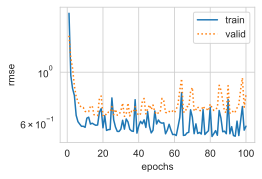

fold  0 ,train rmse 0.582529,valid rmse 0.798757


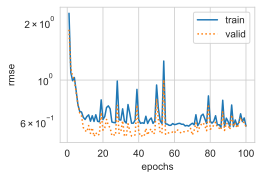

fold  1 ,train rmse 0.572737,valid rmse 0.568407


In [ ]:
k,num_epochs,lr,weight_decay,batch_size = 5,100,0.01,0,80
train_l,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation: avg train rmse %f,avg valid rmse %f' % (k,train_l,valid_l))

In [ ]:
import seaborn as sns

In [ ]:
def train_and_pred(train_featrues,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net = get_net()
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    sns.displot(train_ls)
    preds = net(test_features).asnumpy()
    test_data['tested_positive.4'] = pd.Series(preds.reshape(1,-1)[0])
    sumbmission = pd.concat([test_data['id'],test_data['tested_positive.4']],axis=1)
    sumbmission.to_csv('submission.csv',index=False)
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)